In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate, Conv2DTranspose, Activation, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import resnet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import numpy as np
import os
import pandas as pd

In [2]:
from google.colab import drive
drive.mount('/content/drive/')


GOOGLE_DRIVE_TRAINING_PATH_AFTER_MYDRIVE = 'AI_Project_Files/Filtered_Training'
GOOGLE_DRIVE_TESTING_PATH_AFTER_MYDRIVE = 'AI_Project_Files/Filtered_Testing'

GOOGLE_DRIVE_TRAINING_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TRAINING_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_TESTING_PATH = os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TESTING_PATH_AFTER_MYDRIVE)


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
GOOGLE_DRIVE_TRAINING_LABELS_PATH_AFTER_MYDRIVE = 'AI_Project_Files/filtered_training_csvfile.csv'
GOOGLE_DRIVE_TESTING_LABELS_PATH_AFTER_MYDRIVE = 'AI_Project_Files/filtered_testing_csvfile.csv'

GOOGLE_DRIVE_TRAINING_LABELS_PATH =  os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TRAINING_LABELS_PATH_AFTER_MYDRIVE)
GOOGLE_DRIVE_TESTING_LABELS_PATH =  os.path.join('drive', 'MyDrive', GOOGLE_DRIVE_TESTING_LABELS_PATH_AFTER_MYDRIVE)

**Paths for Training**
- Images: `GOOGLE_DRIVE_TRAINING_PATH`
- Labels: `GOOGLE_DRIVE_TRAINING_LABELS_PATH`

**Paths for Testing**
- Images: `GOOGLE_DRIVE_TESTING_PATH`
- Labels: `GOOGLE_DRIVE_TESTING_LABELS_PATH`

In [4]:
# loading training dataset
df = pd.read_csv(GOOGLE_DRIVE_TRAINING_LABELS_PATH)


In [5]:
df['image_name'] = df['id'].map('seq_{:06d}.jpg'.format)

def getClass(classification):
  if (classification == 'Crowded'):
    return 1
  return 0


df['class'] = df['Classification'].map(getClass)

print(df)

       id Classification      image_name  class
0     404    Not Crowded  seq_000404.jpg      0
1     405    Not Crowded  seq_000405.jpg      0
2     410        Crowded  seq_000410.jpg      1
3     411        Crowded  seq_000411.jpg      1
4     412        Crowded  seq_000412.jpg      1
..    ...            ...             ...    ...
945  1989    Not Crowded  seq_001989.jpg      0
946  1990    Not Crowded  seq_001990.jpg      0
947  1998    Not Crowded  seq_001998.jpg      0
948  1999    Not Crowded  seq_001999.jpg      0
949  2000    Not Crowded  seq_002000.jpg      0

[950 rows x 4 columns]


In [6]:
df['Classification'].describe()


count         950
unique          2
top       Crowded
freq          538
Name: Classification, dtype: object

In [7]:
size = 224
batch_size = 64

In [8]:
from keras.applications.resnet50 import preprocess_input

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)



# Data generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=GOOGLE_DRIVE_TRAINING_PATH,
    x_col='image_name',
    y_col='Classification',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=df,
    directory=GOOGLE_DRIVE_TRAINING_PATH,
    x_col='image_name',
    y_col='Classification',
    target_size=(size, size),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 760 validated image filenames belonging to 2 classes.
Found 190 validated image filenames belonging to 2 classes.


In [9]:
def Crowd_Density_Detection(input_shape):
    base_model = resnet50.ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Conv2D(512, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    predict = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predict)
    return model


In [10]:
input_shape = (size, size, 3)
model = Crowd_Density_Detection(input_shape)
model.compile(optimizer=Adam(learning_rate=0.001), loss='BinaryCrossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(train_generator,epochs = 30, validation_data = valid_generator,verbose=2)

Epoch 1/30
12/12 - 102s - loss: 0.4506 - accuracy: 0.7947 - val_loss: 2.5094 - val_accuracy: 0.7000 - 102s/epoch - 9s/step
Epoch 2/30
12/12 - 14s - loss: 0.2833 - accuracy: 0.8921 - val_loss: 2.5281 - val_accuracy: 0.6211 - 14s/epoch - 1s/step
Epoch 3/30
12/12 - 13s - loss: 0.2962 - accuracy: 0.8921 - val_loss: 0.4777 - val_accuracy: 0.8632 - 13s/epoch - 1s/step
Epoch 4/30
12/12 - 14s - loss: 0.2100 - accuracy: 0.9092 - val_loss: 2.0396 - val_accuracy: 0.6158 - 14s/epoch - 1s/step
Epoch 5/30
12/12 - 13s - loss: 0.1673 - accuracy: 0.9395 - val_loss: 1.4931 - val_accuracy: 0.7000 - 13s/epoch - 1s/step
Epoch 6/30
12/12 - 14s - loss: 0.2035 - accuracy: 0.9211 - val_loss: 0.7812 - val_accuracy: 0.7105 - 14s/epoch - 1s/step
Epoch 7/30
12/12 - 14s - loss: 0.1994 - accuracy: 0.9145 - val_loss: 2.2909 - val_accuracy: 0.5895 - 14s/epoch - 1s/step
Epoch 8/30
12/12 - 14s - loss: 0.2367 - accuracy: 0.9250 - val_loss: 0.1635 - val_accuracy: 0.9105 - 14s/epoch - 1s/step
Epoch 9/30
12/12 - 13s - loss:

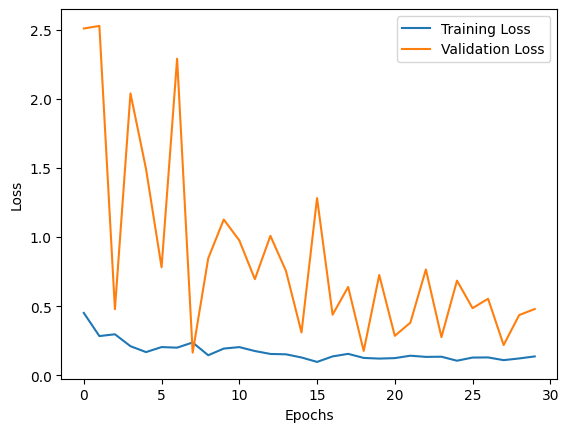

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [13]:
model.save("ResNet_Model.keras")

In [14]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
# Evaluate the model on the test set
test_df = pd.read_csv(GOOGLE_DRIVE_TESTING_LABELS_PATH)
test_df['image_name'] = test_df['id'].map('seq_{:06d}.jpg'.format)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=GOOGLE_DRIVE_TESTING_PATH,
    x_col='image_name',
    y_col='Classification',
    target_size=(size, size),
    batch_size= batch_size,
    class_mode='binary',
    shuffle=False
)



Found 174 validated image filenames belonging to 2 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 67 invalid image filename(s) in x_col="image_name". These filename(s) will be ignored.
  warnings.warn(


3/3 [==============================] - 41s 20s/step - loss: 0.1374 - accuracy: 0.9540
Test accuracy: 0.954023003578186
3/3 [==============================] - 2s 277ms/step


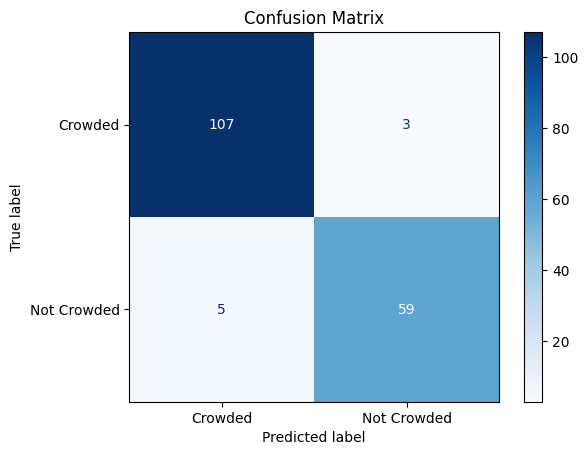

Classification Report
              precision    recall  f1-score   support

 Not Crowded       0.96      0.97      0.96       110
     Crowded       0.95      0.92      0.94        64

    accuracy                           0.95       174
   macro avg       0.95      0.95      0.95       174
weighted avg       0.95      0.95      0.95       174



In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report, ConfusionMatrixDisplay


test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Generate predictions and classification report
test_generator.reset()
Y_pred = model.predict(test_generator)
y_pred = (Y_pred > 0.5).astype(int).reshape(-1)

cm = confusion_matrix(test_generator.classes, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Crowded", "Not Crowded"])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

print('Classification Report')
target_names = ['Not Crowded', 'Crowded']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

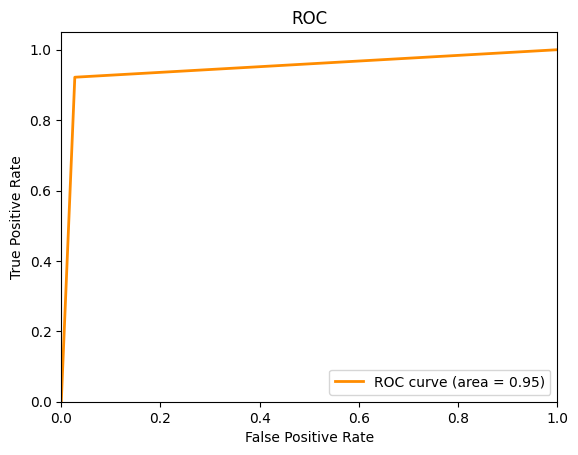

In [18]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(test_generator.classes, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()